In [1]:
from collections import OrderedDict
import cvxpy as cp
import datetime as dt
from loguru import logger
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import typing as t


In [2]:
from quantified_strategies.event_trading import russell_rebalance, super_bowl
from quantified_strategies.overnight_trading import short_term_reversal
from quantified_strategies.seasonal_trading import (
    buy_when_yields_are_low, pay_day_strategy, santa_claus_strategy, september_bear, tax_day_strategy, turn_around_tuesday_strategy)
from quantified_strategies.technical_trading import contrarian_trading

from quantified_strategies import strategy_utils

May need to change to fit other strategy


In [3]:
def get_available(start: dt.date, end: dt.date) -> pd.DataFrame:

    availability_event_trading = pd.concat([
        russell_rebalance.avb.get_availability(start=start, end=END_DATE).to_frame(name="russell_rebalance"),
        super_bowl.avb.get_availability(start=start, end=END_DATE).to_frame(name="super_bowl"),
    ], axis=1)
    availability_event_trading.columns = pd.MultiIndex.from_product(
        [["event_trading"], availability_event_trading.columns.tolist()], names=["type", "name"])
    
    availability_overnight_trading = pd.concat([
        short_term_reversal.avb.get_availability(start=start, end=end).to_frame(name="short_term_reversal"),
    ], axis=1)
    availability_overnight_trading.columns = pd.MultiIndex.from_product(
        [["overnight_trading"], availability_overnight_trading.columns.tolist()], names=["type", "name"])
    
    availability_seasonal_trading = pd.concat([
        buy_when_yields_are_low.avb.get_availability(start=start, end=end).to_frame(name="buy_when_yields_are_low"),
        pay_day_strategy.avb.get_availability(start=start, end=end).to_frame(name="pay_day_strategy"),
        santa_claus_strategy.santa_claus.avb.get_availability(start=start, end=end).to_frame(name="santa_claus_strategy"),
        santa_claus_strategy.sankt_nikolaus.avb.get_availability(start=start, end=end).to_frame(name="sankt_nikolaus_strategy"),
        september_bear.avb.get_availability(start=start, end=end).to_frame(name="september_bear"),
        tax_day_strategy.avb.get_availability(start=start, end=end).to_frame(name="tax_day_strategy"),
        turn_around_tuesday_strategy.avb.get_availability(start=start, end=end).to_frame(name="turn_around_tuesday_strategy"),
    ], axis=1)
    availability_seasonal_trading.columns = pd.MultiIndex.from_product(
        [["seasonal_trading"], availability_seasonal_trading.columns.tolist()], names=["type", "name"])
    
    availability_technical_trading = pd.concat([
        contrarian_trading.avb.get_availability(start=start, end=end).to_frame(name="contrarian_trading"),
    ], axis=1)
    availability_technical_trading.columns = pd.MultiIndex.from_product(
        [["technical_trading"], availability_technical_trading.columns.tolist()], names=["type", "name"])

    availability = pd.concat([
        availability_event_trading, availability_overnight_trading, availability_seasonal_trading, availability_technical_trading,
    ], axis=1)
    availability = availability.sort_index()

    return availability


def get_base_trading(strategy_map: t.Dict[str, str | t.List[str]], start: dt.date, end: dt.date) -> pd.DataFrame:

    def convert_df(dfs: t.List[pd.DataFrame], name: str) -> pd.DataFrame:
        df = pd.concat(dfs, axis=1)

        columns = make_multi_index(
            type=[name], 
            name=list(OrderedDict.fromkeys(df.columns.get_level_values("name"))), 
            ticker=list(OrderedDict.fromkeys(df.columns.get_level_values("ticker"))),
        )
        columns = pd.MultiIndex.from_tuples([tuple(col) for col in columns if col[1:] in df.columns.tolist()])
        df.columns = columns
        
        return df

    def make_multi_index(**kwargs) -> pd.MultiIndex:
        return pd.MultiIndex.from_product(
            [args if isinstance(args, t.List) else [args] for _, args in kwargs.items()], 
            names=[kw for kw in kwargs.keys()]
        )
    

    strategy_map_list = {strat: [universe] if isinstance(universe, str) else universe for strat, universe in strategy_map.items()}
    
    # Define Event Trading
    returns_event_trading = []
    for rr_ticker in strategy_map_list.get("russell_rebalance", []):
        df = russell_rebalance.utils.run(ticker=rr_ticker, start=START_DATE, end=END_DATE).to_frame(name="russell_rebalance")
        df.columns = make_multi_index(name="russell_rebalance", ticker=rr_ticker)
        returns_event_trading.append(df)
    for sb_ticker in strategy_map_list.get("super_bowl", []):
        df = super_bowl.utils.run(ticker=sb_ticker, start=start, end=end).to_frame(name="super_bowl")
        df.columns = make_multi_index(name="super_bowl", ticker=sb_ticker)
        returns_event_trading.append(df)
    returns_event_trading = convert_df(dfs=returns_event_trading, name="event_trading")

    # Define Overnight Trading
    returns_overnight_trading = []
    for str_ticker in strategy_map_list.get("short_term_reversal", []):
        df = short_term_reversal.utils.run(ticker=str_ticker, start=start, end=end).to_frame(name="short_term_reversal")
        df.columns = make_multi_index(name="short_term_reversal", ticker=str_ticker)
        returns_overnight_trading.append(df)
    returns_overnight_trading = convert_df(dfs=returns_overnight_trading, name="overnight_trading")

    # Define Seasonal Trading
    returns_seasonal_trading = []
    ## Global Activity i.e. trigger is NOT auto
    for bwyl_ticker in strategy_map_list.get("buy_when_yields_are_low", []):
        df = buy_when_yields_are_low.utils.run(ticker=bwyl_ticker, start=start, end=end, asset_day_after=TRADED_DAY_AFTER.get(bwyl_ticker, False)).to_frame(name="buy_when_yields_are_low")
        df.columns = make_multi_index(name="buy_when_yields_are_low", ticker=bwyl_ticker)
        returns_seasonal_trading.append(df)
    for pd_ticker in strategy_map_list.get("pay_day_strategy", []):
        df= pay_day_strategy.utils.run(ticker=pd_ticker, start=start, end=end).to_frame(name="pay_day_strategy")
        df.columns = make_multi_index(name="pay_day_strategy", ticker=pd_ticker)
        returns_seasonal_trading.append(df)
    # TODO: Define European ETFs
    for sn_ticker in strategy_map_list.get("sankt_nikolaus_strategy", []):
        df = santa_claus_strategy.sankt_nikolaus.utils.run(ticker=sn_ticker, start=start, end=end).to_frame(name="sankt_nikolaus_strategy")
        df.columns = make_multi_index(name="sankt_nikolaus_strategy", ticker=sn_ticker)
        returns_seasonal_trading.append(df)
    for sc_ticker in strategy_map_list.get("santa_claus_strategy", []):
        df = santa_claus_strategy.santa_claus.utils.run(ticker=sc_ticker, start=start, end=end, close_on_nth_day_in_new_year=5).to_frame(name="santa_claus_strategy")
        df.columns = make_multi_index(name="santa_claus_strategy", ticker=sc_ticker)
        returns_seasonal_trading.append(df)
    for sb_ticker in strategy_map_list.get("september_bear", []):
        df = september_bear.utils.run(ticker=sb_ticker, start=start, end=end, xday=4, week_enter=3, cover_duration=1).to_frame(name="september_bear")
        df.columns = make_multi_index(name="september_bear", ticker=sb_ticker)
        returns_seasonal_trading.append(df)
    for td_ticker in strategy_map_list.get("tax_day_strategy", []):
        df = tax_day_strategy.utils.run(ticker=td_ticker, start=start, end=end, enter_before=dict(month=3, day=31), exit_after=dict(month=4, day=15)).to_frame(name="tax_day_strategy")
        df.columns = make_multi_index(name="tax_day_strategy", ticker=td_ticker)
        returns_seasonal_trading.append(df)
    ## Auto-Activity i.e. trigger is correlated to ticker
    for tat_ticker in strategy_map_list.get("turn_around_tuesday_strategy", []):
        df = turn_around_tuesday_strategy.utils.run(ticker=tat_ticker, start=start, end=end).to_frame(name="turn_around_tuesday_strategy")
        df.columns = make_multi_index(name="turn_around_tuesday_strategy", ticker=tat_ticker)
        returns_seasonal_trading.append(df)
    # returns_seasonal_trading["turn_around_tuesday(QQQ)"] = turn_around_tuesday_strategy.utils.run(ticker="QQQ", start=start, end=end)
    returns_seasonal_trading = convert_df(dfs=returns_seasonal_trading, name="seasonal_trading")

    returns_df = pd.concat([returns_event_trading, returns_overnight_trading, returns_seasonal_trading], axis=1)
    returns_df = returns_df.sort_index()

    return returns_df
        

In [4]:

def get_change_dataframe(data: pd.DataFrame, start: dt.date) -> pd.DataFrame:
    
    dfs = []
    for i, columns in enumerate(data.columns):
    
        ticker = None
        if len(columns) == 2:
            _, strat_name = columns
        elif len(columns) == 3:
            _, strat_name, ticker = columns

        logger.info(f"Getting changes in {strat_name = !r}")
        
        a = data.iloc[:, i].fillna(False)
        changes = a[a.diff().fillna(1) != 0.0]
    
        df = pd.DataFrame({"start": changes.index, "end": changes.index[1:].tolist() + [a.index[-1]], "value": changes.values})
        df = df.loc[df["value"] != 0.0]
        df["strategy"] = strat_name
        if ticker is not None:
            df["asset"] = ticker
        df["days_to_start"] = (df["start"] - start).dt.days
        df["days_completed"] = (df["end"].clip(upper=pd.Timestamp(dt.date.today())) - start).dt.days
        df["days_to_end"] = (df["end"] - start).dt.days
        df["task_duration"] = df["days_to_end"] - df["days_to_start"] + 1  # to include also the end date
        df["completion_days"] = df["task_duration"] * (df["days_completed"] - df["days_to_start"]) / (df["days_to_end"] - df["days_to_start"])
        dfs.append(df)
    
    df = pd.concat(dfs, axis=0)
    df = df.reset_index(drop=True)

    return df

def plot(availability: pd.DataFrame, activity: pd.DataFrame = None, 
         change_availability: pd.DataFrame = None, change_activity: pd.DataFrame = None) -> None:

    def plot_dataframe(actual: pd.DataFrame, change: pd.DataFrame, color: str):
        change = get_change_dataframe(data=actual, start=availability.index[0]) if change is None else change
        
        ax.barh(
            y=change["strategy"], 
            width=change["task_duration"], 
            left=change["days_to_start"],
            color=color,
            alpha=0.2,
        )

        ax.barh(
            y=change["strategy"], 
            width=change["completion_days"], 
            left=change["days_to_start"],
            color=color,
        )
        return

    def format_plot():
        
        plt.gca().invert_yaxis()

        # Fetch all indices
        list_of_indices = availability.index.tolist()
        today_index = list_of_indices.index(pd.Timestamp(dt.date.today()))
        ax.axvline(x=today_index, color="red", linestyle="--")
        ax.text(x=today_index + 0.5, y=availability.shape[1] - 1 + 0.33, s=f"{dt.date.today():%d-%m}", color="r")
        
        # Get indices you want to show
        x_tick_labels = pd.date_range(start=list_of_indices[0], end=list_of_indices[-1], freq="YS")
        # Get index of each date in labels
        x_ticks = [list_of_indices.index(label) for label in x_tick_labels]
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([date.date() for date in x_tick_labels])

        ax.xaxis.grid(True, alpha=0.5)
        
        plt.title("Strategy Calendar", fontsize=15)
        plt.legend(handles=[matplotlib.patches.Patch(color=color) for _, color in color_map.items()], 
                   labels=color_map.keys(), fontsize=11, bbox_to_anchor=(1.1, 1.05))

        return

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    color_map = {"available": colors[0], "active": colors[1]}

    fig, ax = plt.subplots(figsize=(15, 7))

    plot_dataframe(actual=availability, change=change_availability, color=color_map["available"])
    if activity is not None:
        plot_dataframe(actual=activity, change=change_activity, color=color_map["active"])
    else:
        del color_map["active"]
    format_plot()

    plt.show()

    return




## Portfolio Optimization

### Define Start and End Date for Portfolio

In [5]:
START_DATE = dt.date(2000, 1, 1)
END_DATE = dt.date.today()

### Define Strategy Universe

In [6]:
US_INDICES = ["SPY", "QQQ"]
# US_INDICES = ["SPY", "QQQ", "XLC", "XLE", "XLF", "XLI", "XLK", "XLP", "XLRE", "XLU", "XLY", "XLV"]
US_INDICES = ["VUSA.L", "CNX1.L"] 

TRADED_DAY_AFTER = {asset: True for asset in US_INDICES}

strategy_universe_map = {
    # "russell_rebalance": "IWM",
    # "sankt_nikolaus_strategy": "EWG",
    "super_bowl": US_INDICES,
    "short_term_reversal": US_INDICES,
    "buy_when_yields_are_low": US_INDICES,
    "pay_day_strategy": US_INDICES,
    "santa_claus_strategy": US_INDICES,
    "september_bear": US_INDICES,
    "tax_day_strategy": US_INDICES,
    "turn_around_tuesday_strategy": US_INDICES,
}
strategy_universe_map

{'super_bowl': ['VUSA.L', 'CNX1.L'],
 'short_term_reversal': ['VUSA.L', 'CNX1.L'],
 'buy_when_yields_are_low': ['VUSA.L', 'CNX1.L'],
 'pay_day_strategy': ['VUSA.L', 'CNX1.L'],
 'santa_claus_strategy': ['VUSA.L', 'CNX1.L'],
 'september_bear': ['VUSA.L', 'CNX1.L'],
 'tax_day_strategy': ['VUSA.L', 'CNX1.L'],
 'turn_around_tuesday_strategy': ['VUSA.L', 'CNX1.L']}

### Get when Strategies are possible to trade

In [ ]:
availability = get_available(start=START_DATE, end=END_DATE)
availability.head(5)

### Get returns from trading each strategy

In [7]:
base_returns_df = get_base_trading(strategy_map=strategy_universe_map, start=START_DATE, end=END_DATE)
base_returns_df = base_returns_df.sort_index()
base_returns_df.head(5)

Check i don't need to adjust for time of day: not trading the future
Check i don't need to adjust for time of day: not trading the future


event_trading          overnight_trading         \
              super_bowl        short_term_reversal          
                  VUSA.L CNX1.L              VUSA.L CNX1.L   
Date                                                         
2010-01-27           NaN    NaN                 NaN    NaN   
2010-01-28           NaN    NaN                 NaN    NaN   
2010-01-29           NaN    NaN                 NaN    NaN   
2010-02-01           NaN    NaN                 NaN    NaN   
2010-02-02           NaN    NaN                 NaN    NaN   

                  seasonal_trading                                       \
           buy_when_yields_are_low           pay_day_strategy             
                            VUSA.L    CNX1.L           VUSA.L    CNX1.L   
Date                                                                      
2010-01-27                     NaN -0.016971              NaN -0.026229   
2010-01-28                     NaN   0.01128              NaN -0.016971   
2010-01-29                     NaN  0.009189              NaN   0.01128   
2010-02-01                     NaN  0.004524              NaN  0.009189   
2010-02-02                     NaN -0.028977              NaN       NaN   

                                                                               \
           santa_claus_strategy        september_bear        tax_day_strategy   
                         VUSA.L CNX1.L         VUSA.L CNX1.L           VUSA.L   
Date                                                                            
2010-01-27                  NaN    NaN            NaN    NaN              NaN   
2010-01-28                  NaN    NaN            NaN    NaN              NaN   
2010-01-29                  NaN    NaN            NaN    NaN              NaN   
2010-02-01                  NaN    NaN            NaN    NaN              NaN   
2010-02-02                  NaN    NaN            NaN    NaN              NaN   

                                                       
                  turn_around_tuesday_strategy         
           CNX1.L                       VUSA.L CNX1.L  
Date                                                   
2010-01-27    NaN                          NaN    NaN  
2010-01-28    NaN                          NaN    NaN  
2010-01-29    NaN                          NaN    NaN  
2010-02-01    NaN                          NaN    NaN  
2010-02-02    NaN                          NaN    NaN

In [8]:
base_returns_df

event_trading            overnight_trading         \
              super_bowl          short_term_reversal          
                  VUSA.L   CNX1.L              VUSA.L CNX1.L   
Date                                                           
2010-01-27           NaN      NaN                 NaN    NaN   
2010-01-28           NaN      NaN                 NaN    NaN   
2010-01-29           NaN      NaN                 NaN    NaN   
2010-02-01           NaN      NaN                 NaN    NaN   
2010-02-02           NaN      NaN                 NaN    NaN   
...                  ...      ...                 ...    ...   
2024-02-22       0.00174 -0.00373                 NaN    NaN   
2024-02-23           NaN      NaN                 NaN    NaN   
2024-02-26           NaN      NaN                 NaN    NaN   
2024-02-27           NaN      NaN                 NaN    NaN   
2024-02-28           NaN      NaN                 NaN    NaN   

                  seasonal_trading                                       \
           buy_when_yields_are_low           pay_day_strategy             
                            VUSA.L    CNX1.L           VUSA.L    CNX1.L   
Date                                                                      
2010-01-27                     NaN -0.016971              NaN -0.026229   
2010-01-28                     NaN   0.01128              NaN -0.016971   
2010-01-29                     NaN  0.009189              NaN   0.01128   
2010-02-01                     NaN  0.004524              NaN  0.009189   
2010-02-02                     NaN -0.028977              NaN       NaN   
...                            ...       ...              ...       ...   
2024-02-22                     NaN       NaN              NaN       NaN   
2024-02-23                     NaN       NaN        -0.001868 -0.000266   
2024-02-26                     NaN       NaN        -0.004171  0.002095   
2024-02-27                     NaN       NaN         0.002803       NaN   
2024-02-28                     NaN       NaN              NaN       NaN   

                                                                               \
           santa_claus_strategy        september_bear        tax_day_strategy   
                         VUSA.L CNX1.L         VUSA.L CNX1.L           VUSA.L   
Date                                                                            
2010-01-27                  NaN    NaN            NaN    NaN              NaN   
2010-01-28                  NaN    NaN            NaN    NaN              NaN   
2010-01-29                  NaN    NaN            NaN    NaN              NaN   
2010-02-01                  NaN    NaN            NaN    NaN              NaN   
2010-02-02                  NaN    NaN            NaN    NaN              NaN   
...                         ...    ...            ...    ...              ...   
2024-02-22                  NaN    NaN            NaN    NaN              NaN   
2024-02-23                  NaN    NaN            NaN    NaN              NaN   
2024-02-26                  NaN    NaN            NaN    NaN              NaN   
2024-02-27                  NaN    NaN            NaN    NaN              NaN   
2024-02-28                  NaN    NaN            NaN    NaN              NaN   

                                                          
                  turn_around_tuesday_strategy            
           CNX1.L                       VUSA.L    CNX1.L  
Date                                                      
2010-01-27    NaN                          NaN       NaN  
2010-01-28    NaN                          NaN       NaN  
2010-01-29    NaN                          NaN       NaN  
2010-02-01    NaN                          NaN       NaN  
2010-02-02    NaN                          NaN       NaN  
...           ...                          ...       ...  
2024-02-22    NaN                          NaN       NaN  
2024-02-23    NaN                          NaN       NaN  


### Get when Strategies are actively trading

In [9]:
activity = ~base_returns_df.isna()
activity.head(5)

event_trading          overnight_trading         \
              super_bowl        short_term_reversal          
                  VUSA.L CNX1.L              VUSA.L CNX1.L   
Date                                                         
2010-01-27         False  False               False  False   
2010-01-28         False  False               False  False   
2010-01-29         False  False               False  False   
2010-02-01         False  False               False  False   
2010-02-02         False  False               False  False   

                  seasonal_trading                                 \
           buy_when_yields_are_low        pay_day_strategy          
                            VUSA.L CNX1.L           VUSA.L CNX1.L   
Date                                                                
2010-01-27                   False   True            False   True   
2010-01-28                   False   True            False   True   
2010-01-29                   False   True            False   True   
2010-02-01                   False   True            False   True   
2010-02-02                   False   True            False  False   

                                                                               \
           santa_claus_strategy        september_bear        tax_day_strategy   
                         VUSA.L CNX1.L         VUSA.L CNX1.L           VUSA.L   
Date                                                                            
2010-01-27                False  False          False  False            False   
2010-01-28                False  False          False  False            False   
2010-01-29                False  False          False  False            False   
2010-02-01                False  False          False  False            False   
2010-02-02                False  False          False  False            False   

                                                       
                  turn_around_tuesday_strategy         
           CNX1.L                       VUSA.L CNX1.L  
Date                                                   
2010-01-27  False                        False  False  
2010-01-28  False                        False  False  
2010-01-29  False                        False  False  
2010-02-01  False                        False  False  
2010-02-02  False                        False  False

### Get changes in strategies availability to trade

In [ ]:
change_availability = get_change_dataframe(data=availability, start=availability.index[0])
change_availability

### Get changes in strategy activity

In [10]:
change_activity = get_change_dataframe(data=activity, start=availability.index[0])
change_activity

NameError: name 'availability' is not defined

## Plot availability to trade versus strategy actviity

In [ ]:
plot(availability=availability, activity=activity, change_availability=change_availability, change_activity=change_activity)

In [10]:
base_returns_df

event_trading            overnight_trading         \
              super_bowl          short_term_reversal          
                  VUSA.L   CNX1.L              VUSA.L CNX1.L   
Date                                                           
2010-01-27           NaN      NaN                 NaN    NaN   
2010-01-28           NaN      NaN                 NaN    NaN   
2010-01-29           NaN      NaN                 NaN    NaN   
2010-02-01           NaN      NaN                 NaN    NaN   
2010-02-02           NaN      NaN                 NaN    NaN   
...                  ...      ...                 ...    ...   
2024-02-22       0.00174 -0.00373                 NaN    NaN   
2024-02-23           NaN      NaN                 NaN    NaN   
2024-02-26           NaN      NaN                 NaN    NaN   
2024-02-27           NaN      NaN                 NaN    NaN   
2024-02-28           NaN      NaN                 NaN    NaN   

                  seasonal_trading                                       \
           buy_when_yields_are_low           pay_day_strategy             
                            VUSA.L    CNX1.L           VUSA.L    CNX1.L   
Date                                                                      
2010-01-27                     NaN -0.016971              NaN -0.026229   
2010-01-28                     NaN   0.01128              NaN -0.016971   
2010-01-29                     NaN  0.009189              NaN   0.01128   
2010-02-01                     NaN  0.004524              NaN  0.009189   
2010-02-02                     NaN -0.028977              NaN       NaN   
...                            ...       ...              ...       ...   
2024-02-22                     NaN       NaN              NaN       NaN   
2024-02-23                     NaN       NaN        -0.001868 -0.000266   
2024-02-26                     NaN       NaN        -0.004171  0.002095   
2024-02-27                     NaN       NaN         0.002803       NaN   
2024-02-28                     NaN       NaN              NaN       NaN   

                                                                               \
           santa_claus_strategy        september_bear        tax_day_strategy   
                         VUSA.L CNX1.L         VUSA.L CNX1.L           VUSA.L   
Date                                                                            
2010-01-27                  NaN    NaN            NaN    NaN              NaN   
2010-01-28                  NaN    NaN            NaN    NaN              NaN   
2010-01-29                  NaN    NaN            NaN    NaN              NaN   
2010-02-01                  NaN    NaN            NaN    NaN              NaN   
2010-02-02                  NaN    NaN            NaN    NaN              NaN   
...                         ...    ...            ...    ...              ...   
2024-02-22                  NaN    NaN            NaN    NaN              NaN   
2024-02-23                  NaN    NaN            NaN    NaN              NaN   
2024-02-26                  NaN    NaN            NaN    NaN              NaN   
2024-02-27                  NaN    NaN            NaN    NaN              NaN   
2024-02-28                  NaN    NaN            NaN    NaN              NaN   

                                                          
                  turn_around_tuesday_strategy            
           CNX1.L                       VUSA.L    CNX1.L  
Date                                                      
2010-01-27    NaN                          NaN       NaN  
2010-01-28    NaN                          NaN       NaN  
2010-01-29    NaN                          NaN       NaN  
2010-02-01    NaN                          NaN       NaN  
2010-02-02    NaN                          NaN       NaN  
...           ...                          ...       ...  
2024-02-22    NaN                          NaN       NaN  
2024-02-23    NaN                          NaN       NaN  


In [11]:
base_returns_df.to_csv(f"outputs/strategy_returns_alternative.csv")

In [23]:
trading_start = dt.date(START_DATE.year+1, START_DATE.month, START_DATE.day)
trade_end = END_DATE
trading_start = dt.date(2023, 1, 1)
# trade_end = dt.date(2017, 1, 1)
trading_dates = pd.date_range(start=trading_start, end=trade_end)
trading_dates = [date for date in trading_dates if date in activity.index]

strategy_returns = dict()
for trade_date in trading_dates:
    
    is_active = activity.loc[trade_date]
    active_strats = is_active[is_active].index.tolist()
    
    if len(active_strats) == 0:
        strategy_returns[trade_date] = None
        continue
    
    df = base_returns_df.loc[:trade_date, active_strats].head(-1)
    # w = strategy_utils.calculate_markowitz_weights(returns_df=df)
    w = pd.Series(1 / len(active_strats), index=active_strats, dtype=float)
    
    strat_ret = (base_returns_df.loc[trade_date, active_strats] * w).sum()
    strategy_returns[trade_date] = strat_ret
    
    
strategy_returns = pd.Series(strategy_returns)
strategy_returns

2023-01-03    0.006479
2023-01-04   -0.009422
2023-01-05    0.016142
2023-01-06    0.006242
2023-01-09    0.015982
                ...   
2024-02-22   -0.000995
2024-02-23   -0.001067
2024-02-26   -0.001038
2024-02-27    0.003232
2024-02-28         NaN
Length: 293, dtype: float64

In [24]:
strategy_returns

2023-01-03    0.006479
2023-01-04   -0.009422
2023-01-05    0.016142
2023-01-06    0.006242
2023-01-09    0.015982
                ...   
2024-02-22   -0.000995
2024-02-23   -0.001067
2024-02-26   -0.001038
2024-02-27    0.003232
2024-02-28         NaN
Length: 293, dtype: float64

<Axes: >

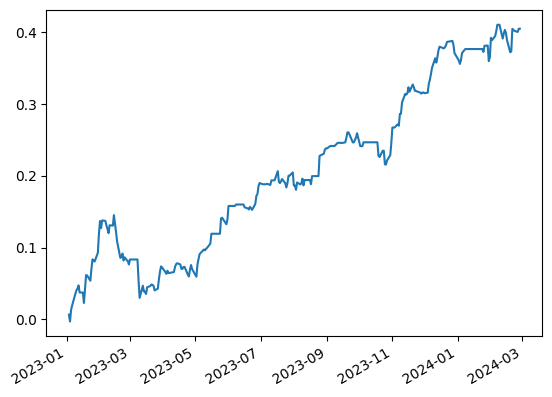

In [25]:
cum_strat_return = strategy_utils.get_cumulative_return(returns=strategy_returns[strategy_returns.index.date >= dt.date(2023, 1, 1)].fillna(0.0), total=False)
cum_strat_return.plot()

<Axes: >

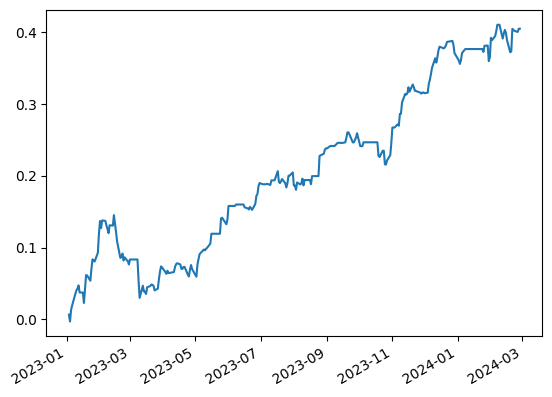

In [26]:
cum_strat_return = strategy_utils.get_cumulative_return(returns=strategy_returns.fillna(0.0), total=False)
cum_strat_return.plot()

In [27]:
strategy_utils.describe(returns=strategy_returns, pos=~(strategy_returns.isna()), daily=True)

Asset                      Undefined
Start                     2023-01-03
End                       2024-02-28
Mean Return                 0.15875%
Total Return                  40.53%
Median Return               0.13378%
1st Quartile               -0.23797%
3rd Quartile                0.61389%
Std Dev Return              0.81136%
CAGR                      15.548 bps
Trade CAGR                    0.794%
Ann. CAGR                    47.919%
Activity Ratio                74.74%
Number of Trades                  43
Average Hold Period        5.09 Days
Daily Sharpe Ratio            0.1957
Ann. Sharpe Ratio              3.106
Adj. Ann. Sharpe Ratio        2.6853
Daily Sortino Ratio           0.2914
Ann. Sortino Ratio            3.9997
Daily Calmar Ratio             4.024
Hit Ratio                     58.45%
Profit Factor                  1.69x
MDD                          -10.07%
MDD Start                 2023-02-14
MDD Bottom                2023-03-10
MDD End                   2023-06-01
M

In [48]:
data = strategy_utils.get_data(ticker="VUSA.L", columns="Adj Close", start=trading_start, end=dt.date.today())
data = strategy_utils.get_data(ticker="CNX1.L", columns="Adj Close", start=trading_start, end=dt.date.today())
data

Date
2023-01-04     61940.511719
2023-01-05     60956.648438
2023-01-06     62653.109375
2023-01-09     63039.199219
2023-01-10     63590.828125
                  ...      
2024-02-21     99631.609375
2024-02-22    102633.132812
2024-02-23    102250.320312
2024-02-26    102223.101562
2024-02-27    102437.257812
Name: Adj Close, Length: 283, dtype: float64

In [49]:
data = data.loc[data.pct_change().abs() < 4 * data.pct_change().std()]
data

Date
2023-01-05     60956.648438
2023-01-06     62653.109375
2023-01-09     63039.199219
2023-01-10     63590.828125
2023-01-11     64706.339844
                  ...      
2024-02-21     99631.609375
2024-02-22    102633.132812
2024-02-23    102250.320312
2024-02-26    102223.101562
2024-02-27    102437.257812
Name: Adj Close, Length: 278, dtype: float64

In [50]:
ret = data.pct_change().shift(-1)
ret = ret.loc[(ret.index >= strategy_returns.index[0]) & (ret.index <= strategy_returns.index[-1])]
ret

Date
2023-01-05    0.027831
2023-01-06    0.006162
2023-01-09    0.008751
2023-01-10    0.017542
2023-01-11    0.004998
                ...   
2024-02-21    0.030126
2024-02-22   -0.003730
2024-02-23   -0.000266
2024-02-26    0.002095
2024-02-27         NaN
Name: Adj Close, Length: 278, dtype: float64

<Axes: xlabel='Date'>

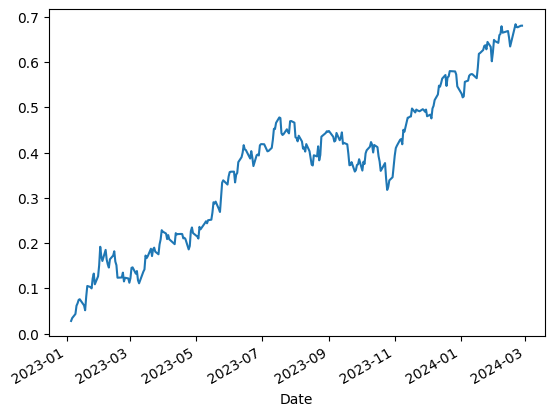

In [51]:
cum_benchmark_return = strategy_utils.get_cumulative_return(returns=ret[ret.index.date >= dt.date(2023, 1, 1)].fillna(0.0), total=False)
cum_benchmark_return.plot()

<Axes: xlabel='Date'>

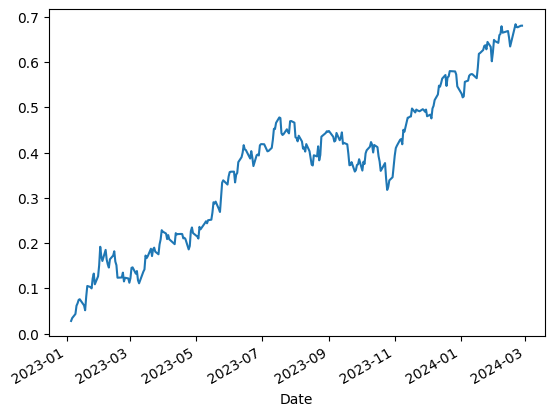

In [52]:
cum_benchmark_return = strategy_utils.get_cumulative_return(returns=ret.fillna(0.0), total=False)
cum_benchmark_return.plot()

In [53]:
strategy_utils.describe(returns=ret, daily=True)

Asset                       Undefined
Start                      2023-01-05
End                        2024-02-27
Mean Return                  0.19405%
Total Return                   68.05%
Median Return                0.11834%
1st Quartile                -0.55494%
3rd Quartile                 0.88959%
Std Dev Return               1.14224%
CAGR                       18.690 bps
Trade CAGR                        N/A
Ann. CAGR                     60.086%
Activity Ratio                100.00%
Number of Trades                  0.0
Average Hold Period       278.00 Days
Daily Sharpe Ratio             0.1699
Ann. Sharpe Ratio              2.6969
Adj. Ann. Sharpe Ratio         2.6969
Daily Sortino Ratio            0.3035
Ann. Sortino Ratio             4.8177
Daily Calmar Ratio             6.2741
Hit Ratio                      57.19%
Profit Factor                   1.55x
MDD                           -10.85%
MDD Start                  2023-07-17
MDD Bottom                 2023-10-25
MDD End     

In [ ]:
import statsmodels.api as sm

In [ ]:
sm.OLS(strategy_returns.fillna(0.0), sm.add_constant(ret.fillna(0.0))).fit().summary()